# $\Delta$-hedging for Asian call options
In this notebook, we explore some $\Delta$-hedging strategies for arithmetic and geometric Asian call options.  For simplicity and to keep the picture clearer, we will assume no transaction costs.

### Finding $\Delta$
We start with geometric Asian options, since we have a closed form.  We compute
$$
\begin{split}
\Delta_{C_0} &= \frac{\partial C_0}{\partial S_0} = \frac{\partial}{\partial S_0} \left( S_0 e^{(b-r)t} \Phi(d_1) - K e^{-rt} \Phi(d_2) \right) \\
&= e^{(b-r)t} \Phi(d_1) + S_0 e^{(b-r)t} \varphi(d_1) \frac{\partial d_1}{\partial S_0} - K e^{-rt} \varphi(d_2) \frac{\partial d_2}{\partial S_0},
\end{split}
$$
where $\varphi(x) = \frac{1}{\sqrt{2\pi}} e^{x^2/2}$ is the density function of the normal distribution.  Note that
$$
\frac{\partial d_2}{\partial S_0} = \frac{\partial}{\partial S_0} \left(d_1 - \sigma\sqrt{t/3}\right) = \frac{\partial d_1}{\partial S_0},
$$
and that
$$
\begin{split}
&S_0 e^{(b-r)t} \varphi(d_1) - K e^{-rt} \varphi(d_2) = S_0 e^{(b-r)t} \frac{1}{\sqrt{2\pi}} e^{-d_1^2/2} - K e^{-rt} \frac{1}{\sqrt{2\pi}} e^{-d_1^2/2} e^{\sigma^2 t / 6} \\
&\qquad= \frac{e^{-d_1^2/2}}{\sqrt{2\pi}} \left(S_0 e^{(b-r)t} - K e^{-rt} e^{\frac{\sigma\sqrt{t}}{\sqrt{3}}d_1} e^{-\sigma^2 t / 6} \right) \\
&\qquad= \varphi(d_1) \left( S_0 e^{(b-r)t} - K e^{-rt} e^{\ln \frac{S_0}{K} + bt + \frac{\sigma^2 t}{6}} e^{-\frac{\sigma^2 t}{6}} \right) = 0.
\end{split}
$$
Hence, we conclude that 
$$
\Delta_{C_0} = e^{(b-r)t} \Phi(d_1).
$$
By put-call parity, we also find the delta of a geometric Asian put option:
$$
\Delta_{P_0} = \Delta_{C_0} - e^{(b-r)t} = e^{(b-r)t} \left( \Phi(d_1) - 1 \right).
$$
The following code implements geometric deltas and is available in `utils.py`.
```python
def gao_delta(S0, K, sigma, t, r, option_type='call'):
    '''Geometric Asian option delta
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma (float): Yearly volatility
    t (float): Time to expiration (years)
    r (float): Risk-free Interest rate
    
    Return:
    Delta of a geometric Asian call/put option (float)
    '''
    b = (r - sigma**2 / 6) / 2
    d1 = np.sqrt(3)*(np.log(S0/K) + (b + sigma**2 / 6)*t) / (sigma * np.sqrt(t))

    if option_type == 'put':
        return np.exp((b-r)*t) * (norm.cdf(d1) - 1)
    elif option_type == 'call':
        return np.exp((b-r)*t) * norm.cdf(d1)
    else:
        raise ValueError("Unrecognized option type: {}".format(option_type))
```

Since arithmetic Asian options don't have a closed-form solution, we need to resort to numerical approximations.  There are fundamentally two alternatives:
- use the geometric Asian option delta as a proxy for the arithmetic one;
- approximate the arithmetic delta numerically bumping $S_0$ by a small $\varepsilon$ and computing $\Delta_{C_0} \simeq \frac{C_0(S_0 + \varepsilon) - C_0(S_0)}{\varepsilon}$, where $C_0$ is the price of the arithmetic Asian option estimated via Monte-Carlo simulations.

Because the second alternative is computationally very expensive, we will focus on the first approach.  Note that we should expect the delta of a geometric Asian option to be smaller than that of the arithmetic counterpart, at least for a reasonably small volatility, with the difference being of order $O(\sigma\sqrt{t})$.

### Exploratory delta-hedging
With the caveats highlighted above, we try now to implement an exploratory delta-hedging strategy for geometric and arithmetic Asian options.  Because we will be using the closed-form delta from the geometric Asian option for both geometric and arithmetic options, we should expect better performance hedging geometric options.

The following code implements delta-hedging, and is available in `utils.py`.  For simplicity, in our code we will hedge at every simulation step (`n_hedges` and `n_steps` will be the same).
```python
def monte_carlo_asian_hedged(S0, K, sigma, t, r, mu, n_sims, n_steps, geometric=False, return_distribution=True, option_type="call"):
    """
    S0 (float): Underlying stock price at time 0
    sigma (float): Yearly volatility
    t (float): Time to expiration (years)
    r (float): Risk-free interest rate
    mu (float): Drift of log-returns
    n_sims (int): Number of simulated paths
    n_steps (int): Number of steps in the average

    Returns:
    If return_distribution is true, returns distribution of simulated values;
      if false, returns the average payoff of option
    """
    paths = GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps)
    if geometric:
        S = gmean(paths, axis=1)  # geometric mean of prices
    else:
        S = np.mean(paths, axis=1)  # arithmetic mean of prices

    if option_type == "call":
        discounted_payoff = np.exp(-r * t) * np.maximum(S - K, 0)
    elif option_type == "put":
        discounted_payoff = np.exp(-r * t) * np.maximum(K - S, 0)
    else:
        raise ValueError("Unrecognized option type: {}".format(option_type))

    times = np.linspace(0, t, n_steps + 1)
    deltas = gao_delta(paths[:,0:n_steps], K, sigma, (t-times)[0:n_steps], r, option_type=option_type)

    stock_profits_discounted = paths[:,1:n_steps + 1] - paths[:,0:n_steps] * np.exp(r*t/n_steps) * np.exp(-r*times[1:n_steps+1])*deltas
    profit_of_call_with_hedging = discounted_payoff - np.sum(stock_profits_discounted, axis=1)

    if return_distribution:
        return profit_of_call_with_hedging
    else:
        return np.mean(profit_of_call_with_hedging)
```

Below we simulate the effect of the number of samples/hedges on the profit of a market-maker selling a geometric Asian call option.  We assume a transaction price of $0.0020 per transaction.

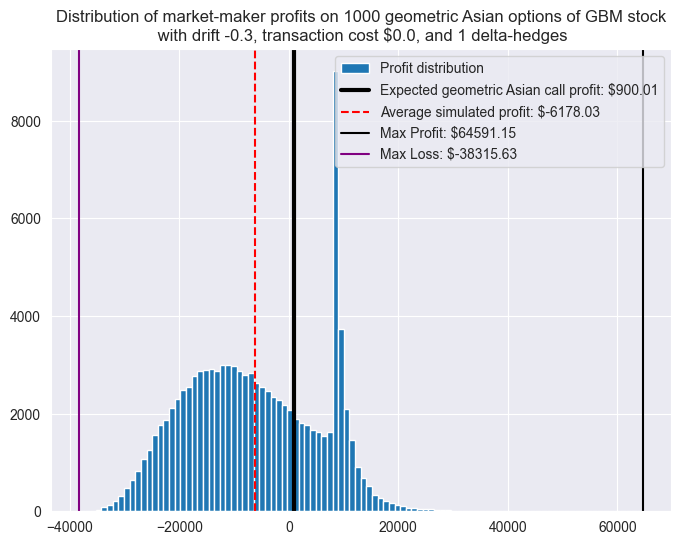

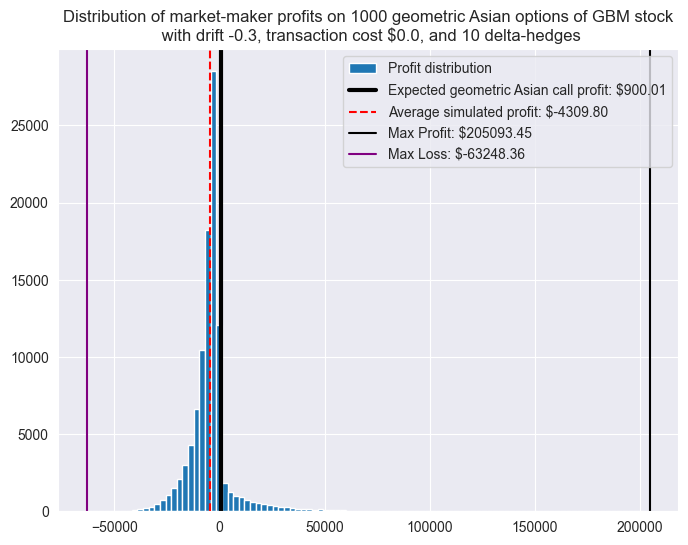

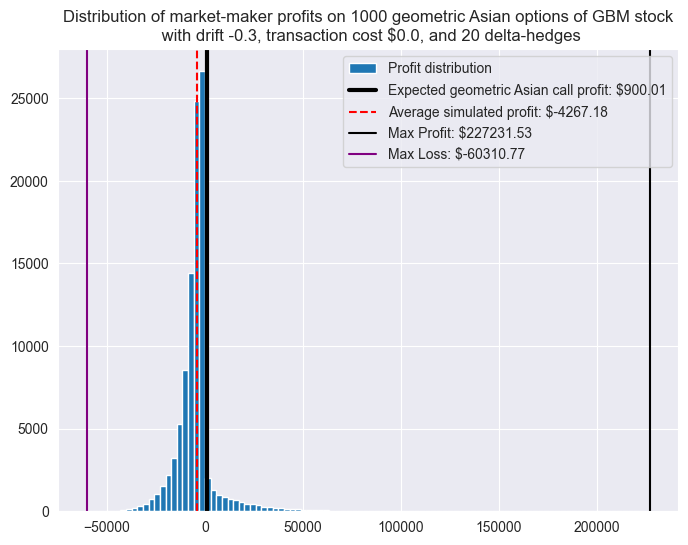

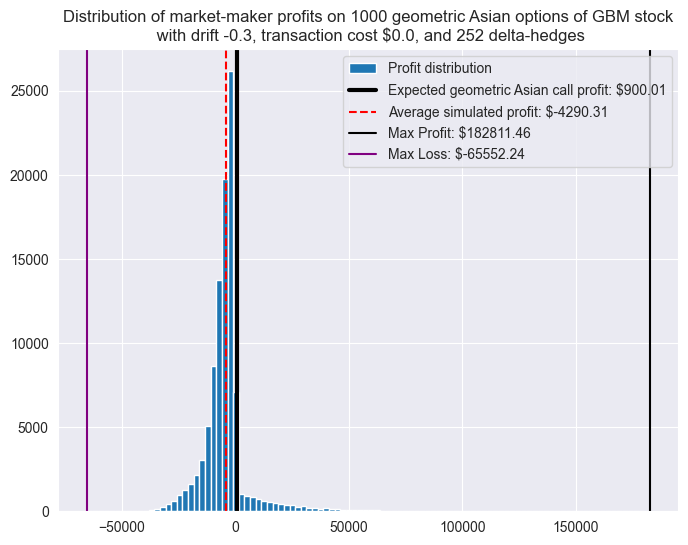

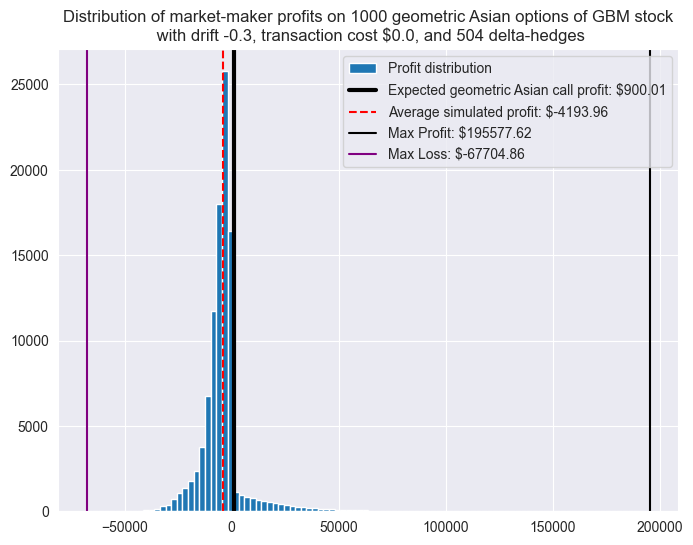

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

from utils import monte_carlo_asian_hedged, gao_price

S0 = 100
K = 100
sigma = 0.41
t = 1
r = 0.045
mu = -0.3
n_sims = 100_000
tr_cost = 0.00
n_options = 1_000
premium = gao_price(S0, K, sigma + 0.05, t, r)

steps_amounts = [1, 10, 20, 252, 504]

for n_steps in steps_amounts:
    call_value_distribution = monte_carlo_asian_hedged(
        S0,
        K,
        sigma,
        t,
        r,
        mu,
        n_sims,
        n_steps,
        geometric=True,
        return_distribution=True,
        option_type="call",
    )

    profit_distribution = n_options * (
        premium - call_value_distribution - tr_cost * n_steps
    )
    average_profit = np.mean(profit_distribution)

    plt.figure(figsize=(8, 6))

    plt.hist(profit_distribution, bins=100, label="Profit distribution")

    plt.axvline(
        n_options * (premium - gao_price(S0, K, sigma, t, r)),
        color="black",
        lw=3,
        label=f"Expected geometric Asian call profit: ${n_options*(premium - gao_price(S0,K,sigma,t,r)):.2f}",
    )

    plt.axvline(
        average_profit,
        ls="--",
        color="red",
        label=f"Average simulated profit: ${average_profit:.2f}",
    )

    profit_max = np.max(profit_distribution)
    profit_min = np.min(profit_distribution)
    plt.axvline(profit_max, color="black", label=f"Max Profit: ${profit_max:.2f}")
    plt.axvline(profit_min, color="purple", label=f"Max Loss: ${profit_min:.2f}")

    plt.title(
        f"Distribution of market-maker profits on {n_options} geometric Asian options of GBM stock\n with drift {mu}, transaction cost ${tr_cost}, and {n_steps} delta-hedges"
    )
    plt.legend()
    plt.show()

Note that the average simulated profit is always significantly less than the expected profit from the analytic formula.  Running the same simulation with a positive drift $\mu = 0.3$, one instead obtains large gains.  This suggests that the hedging strategy is failing somewhere.

One issue might be that the delta-hedging is in fact discarding the path so far, and just computing delta as if the previous path did not matter.  Instead, one should keep track of the path so far, and compute delta conditionally on the (geometric) average up to the point.

One can in fact express the conditional delta in terms of the standard delta with effective parameters.  At time $t_i$:
$$
\Delta_i(S_{t_i}, G_{t_i}) = \frac{\partial S_\text{eff}}{\partial S_{t_i}} \Delta_{C_0}(S_\text{eff}, K, \sigma_\text{eff}, t - t_i),
$$
where $G_{t_i}$ is the geometric average up to time $t_i$, $S_\text{eff} = G_{t_i}^{t_i/t} S_{t_i}^{1 - t_i/t}$ by the properties of geometric averages, and $\sigma_\text{eff} = \sigma \sqrt{\frac{t - t_i}{3t}}$.  One moreover computes $\frac{\partial S_\text{eff}}{\partial S_{t_i}} = \frac{t-t_i}{t} \frac{S_\text{eff}}{S_{t_i}}$.

Another issue is that our delta-hedging simulations so far have assumed that at each rebalancing step we are taking out or depositing the incremental P&L.  In other words, the portfolio does not have zero cash flow before maturity.  In real world, hedging portfolios instead are *self-financing*: at each step the portfolio holds $\Delta_i$ shares of stock and $B_i$ of cash/bonds.  Hence, the portfolio value is $V_i = \Delta_i S_i + B_i$.  The bond grows at the risk-free rate, and thus updates as $B_{i+1} = B_i e^{r dt}$, and there is no cash-flow entering or exiting the portfolio at intermediate times.

### Another attempt at delta-hedging
Here is another trial (from `utils.py`) at implementing a self-financing hedging portfolio for Asian options that takes into account the discussion above.
```python
def mc_asian_sf_hedged(S0, K, sigma, t, r, mu, premium, n_sims, n_steps, geometric=False, option_type="call"):
    """Market-maker's profits on a self-financing Asian option delta-hedging portfolio
    S0 (float): Underlying stock price at time 0
    sigma (float): Yearly volatility
    t (float): Time to expiration (years)
    r (float): Risk-free interest rate
    mu (float): Drift of log-returns
    premium (float): Premium of selling one option
    n_sims (int): Number of simulated paths
    n_steps (int): Number of steps in the average

    Returns:
    If returns 
    """
    dt = t / n_steps

    paths = GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps)

    if geometric:
        S = np.exp(np.mean(np.log(paths), axis=1))  # geometric mean of prices
    else:
        S = np.mean(paths, axis=1)  # arithmetic mean of prices

    if option_type == "call":
        payoff = np.maximum(S - K, 0)
    elif option_type == "put":
        payoff = np.maximum(K - S, 0)
    else:
        raise ValueError("Unrecognized option type: {}".format(option_type))

    # initial delta and bond position
    Delta = gao_delta(S0, K, sigma, t, r, option_type=option_type)
    V = premium
    B = V - Delta * S0

    # initial geometric average (for conditional delta computation)
    G = np.full(n_sims, S0)

    for i in range(n_steps):
        S_next = paths[:, i+1]

        # bond grows at risk-free rate
        B *= np.exp(r * dt)

        # update total portfolio
        V = Delta * S_next + B

        # update geometric average
        G = np.exp( ( (i+1)*np.log(G) + np.log(S_next) ) / (i+2) )

        # compute new delta
        S_eff = G * ((S_next / G)**(1-(i+1)/n_steps))
        sigma_eff = sigma * np.sqrt((1-(i+1)/n_steps)/3)
        tau = t - (i + 1) * dt
        Delta = (1 - (i + 1)/n_steps) * (S_eff / S_next) * gao_delta(S_eff, K, sigma_eff, tau, r, option_type=option_type)

        # rebalance bond position
        B = V - Delta * S_next

    return (V - payoff) * np.exp(-r*t)
```

Below are some simulations with the new approach.

/home/roberto/Desktop/Learning/Quant finance bootcamp/Project/utils.py:98: RuntimeWarning: divide by zero encountered in divide
  d1 = np.sqrt(3)*(np.log(S0/K) + (b + sigma**2 / 6)*t) / (sigma * np.sqrt(t))


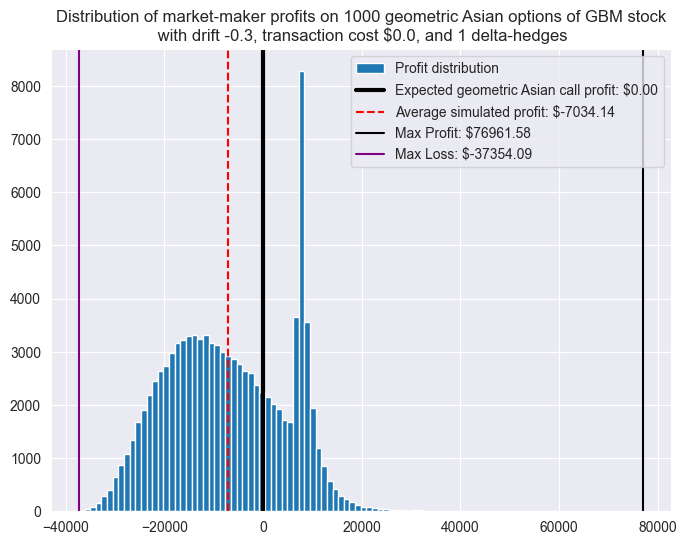

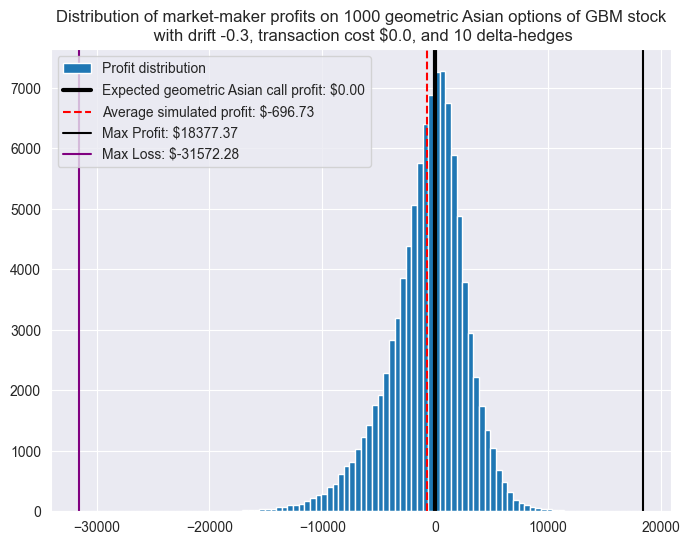

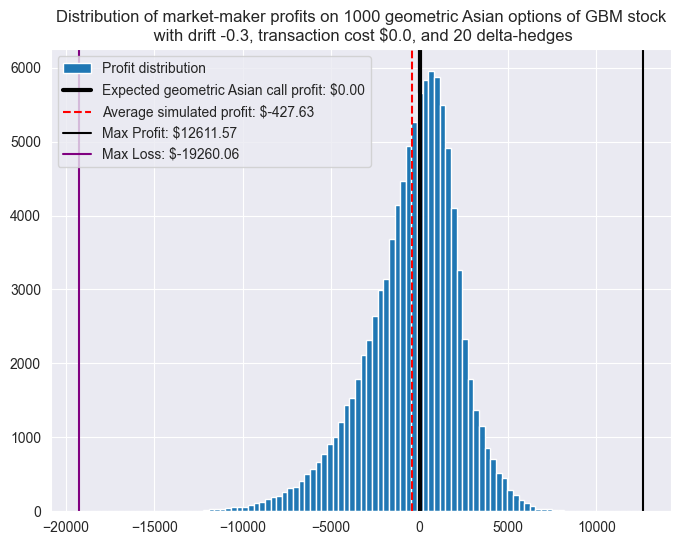

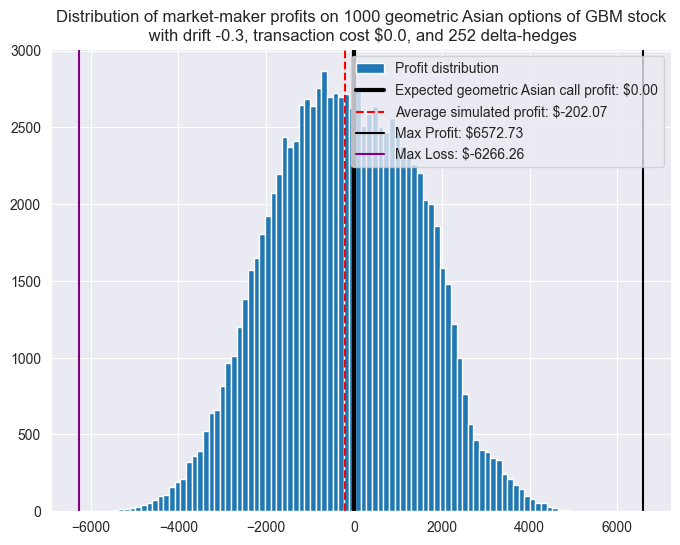

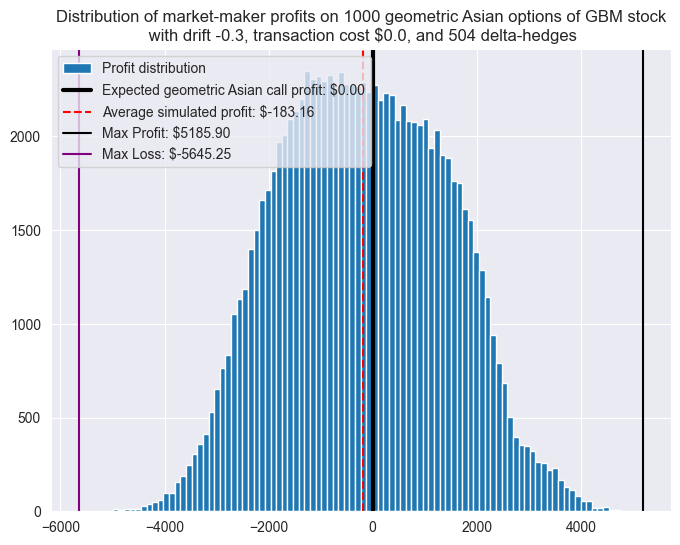

In [2]:
from utils import mc_asian_sf_hedged, gao_price

S0 = 100
K = 100
sigma = 0.41
t = 1
r = 0.045
mu = -0.3
n_sims = 100_000
tr_cost = 0.00
n_options = 1_000
premium = gao_price(S0, K, sigma, t, r)

steps_amounts = [1, 10, 20, 252, 504]

for n_steps in steps_amounts:
    unit_profits_distribution = mc_asian_sf_hedged(
        S0, K, sigma, t, r, mu, premium, n_sims, n_steps, geometric=True
    )

    profit_distribution = n_options * (unit_profits_distribution - tr_cost * n_steps)
    average_profit = np.mean(profit_distribution)

    plt.figure(figsize=(8, 6))

    plt.hist(profit_distribution, bins=100, label="Profit distribution")

    plt.axvline(
        n_options * (premium - gao_price(S0, K, sigma, t, r)),
        color="black",
        lw=3,
        label=f"Expected geometric Asian call profit: ${n_options*(premium - gao_price(S0,K,sigma,t,r)):.2f}",
    )

    plt.axvline(
        average_profit,
        ls="--",
        color="red",
        label=f"Average simulated profit: ${average_profit:.2f}",
    )

    profit_max = np.max(profit_distribution)
    profit_min = np.min(profit_distribution)
    plt.axvline(profit_max, color="black", label=f"Max Profit: ${profit_max:.2f}")
    plt.axvline(profit_min, color="purple", label=f"Max Loss: ${profit_min:.2f}")

    plt.title(
        f"Distribution of market-maker profits on {n_options} geometric Asian options of GBM stock\n with drift {mu}, transaction cost ${tr_cost}, and {n_steps} delta-hedges"
    )
    plt.legend()
    plt.show()

This is still a bit off, but not as much as before.  The distribution of profits looks also more regular, and extreme values are less extreme.  This suggests a partially working hedging strategy, that is however incomplete.  Likely reasons are the mixing continuous geometric average formulas with discrete hedging, and the amount of hedges.  A deeper reason could be the impossibility to perfectly delta hedge Asian options by only trading the underlying asset.

##### Sensibility to drift of geometric Asian options

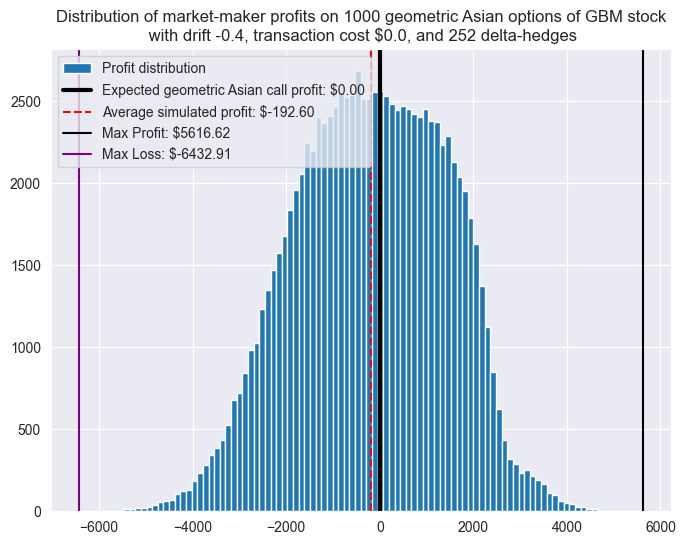

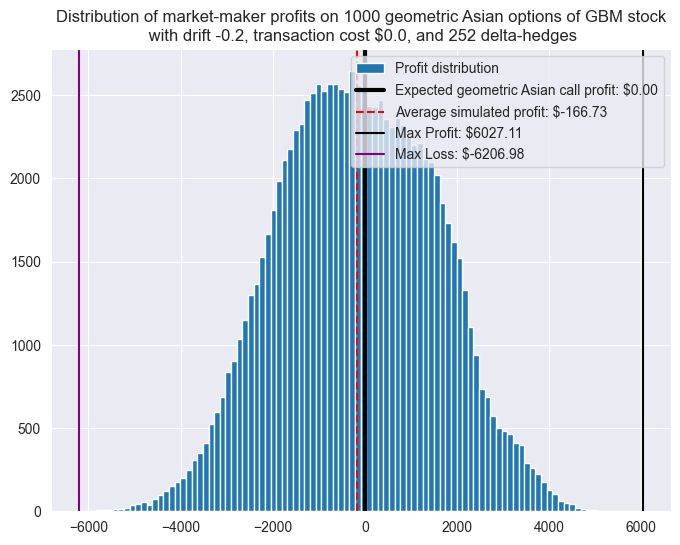

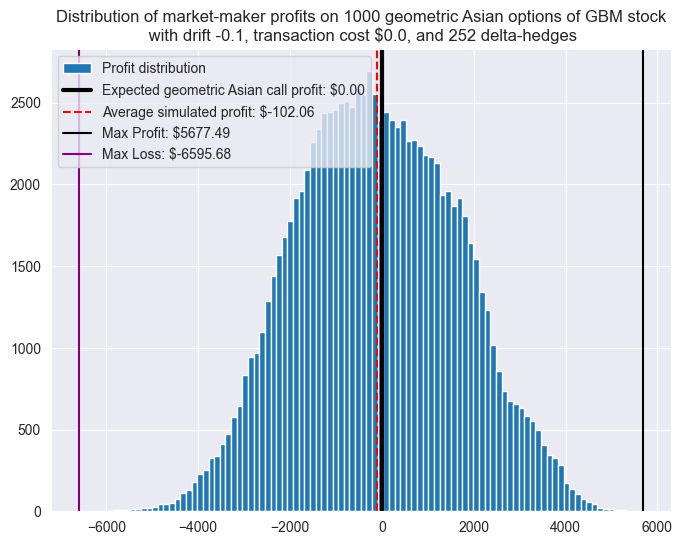

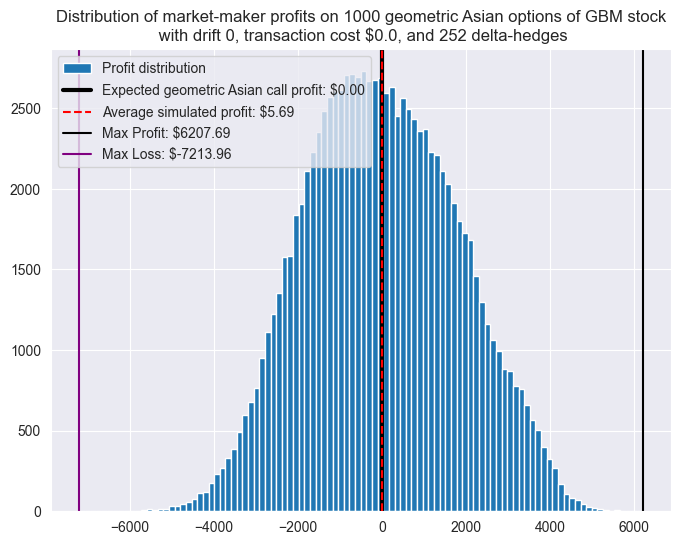

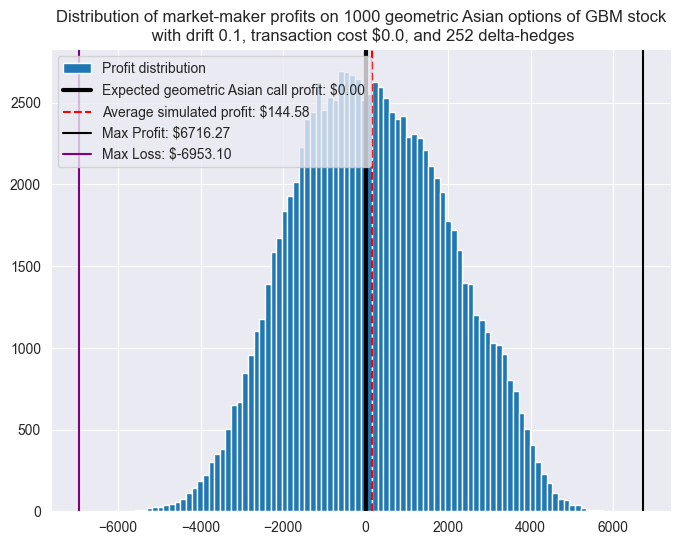

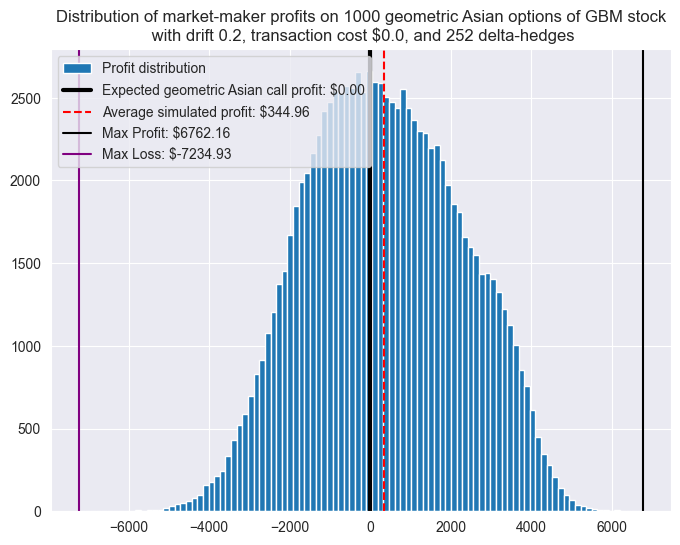

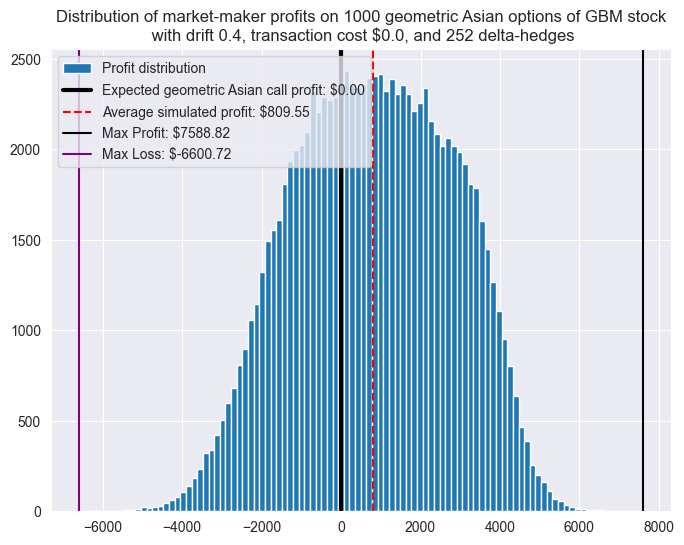

In [12]:
S0 = 100
K = 100
sigma = 0.41
t = 1
r = 0.045
n_sims = 100_000
tr_cost = 0.00
n_options = 1_000
premium = gao_price(S0, K, sigma, t, r)
n_steps = 252

mu_amounts = [-0.4, -0.2, -0.1, 0, 0.1, 0.2, 0.4]
profit_averages = []
profit_stds = []
profit_maxs = []
profit_mins = []

for mu in mu_amounts:
    unit_profits_distribution = mc_asian_sf_hedged(
        S0, K, sigma, t, r, mu, premium, n_sims, n_steps, geometric=True
    )

    profit_distribution = n_options * (unit_profits_distribution - tr_cost * n_steps)
    average_profit = np.mean(profit_distribution)
    profit_averages.append(average_profit)
    profit_stds.append(np.std(profit_distribution))

    plt.figure(figsize=(8, 6))

    plt.hist(profit_distribution, bins=100, label="Profit distribution")

    plt.axvline(
        n_options * (premium - gao_price(S0, K, sigma, t, r)),
        color="black",
        lw=3,
        label=f"Expected geometric Asian call profit: ${n_options*(premium - gao_price(S0,K,sigma,t,r)):.2f}",
    )

    plt.axvline(
        average_profit,
        ls="--",
        color="red",
        label=f"Average simulated profit: ${average_profit:.2f}",
    )

    profit_max = np.max(profit_distribution)
    profit_maxs.append(profit_max)
    profit_min = np.min(profit_distribution)
    profit_mins.append(profit_min)
    plt.axvline(profit_max, color="black", label=f"Max Profit: ${profit_max:.2f}")
    plt.axvline(profit_min, color="purple", label=f"Max Loss: ${profit_min:.2f}")

    plt.title(
        f"Distribution of market-maker profits on {n_options} geometric Asian options of GBM stock\n with drift {mu}, transaction cost ${tr_cost}, and {n_steps} delta-hedges"
    )
    plt.legend()
    plt.show()

ValueError: zero-size array to reduction operation maximum which has no identity

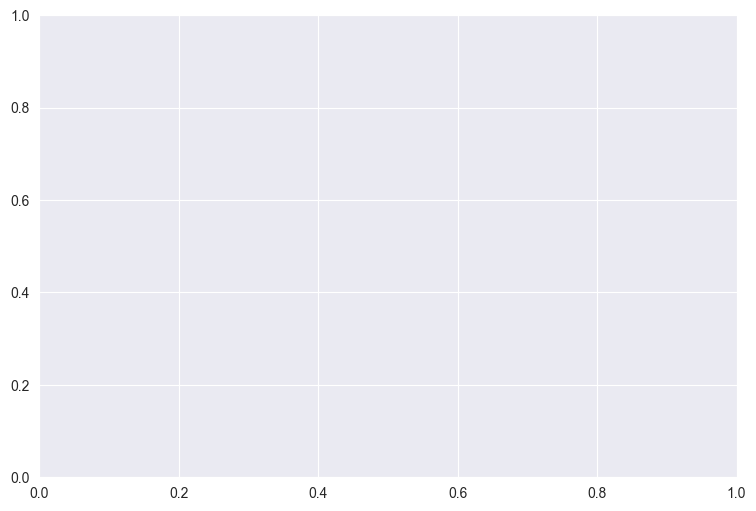

In [ ]:
# draw a box plot
box_data = []
for mean, std, minv, maxv in zip(
    profit_averages, profit_stds, profit_mins, profit_maxs
):
    q1 = mean - 0.5 * std
    q3 = mean + 0.5 * std
    median = mean
    box_data.append(
        {
            "med": median,
            "q1": q1,
            "q3": q3,
            "whislo": minv,  # bottom whisker
            "whishi": maxv,  # top whisker
            "fliers": [],
        }
    )

# Create boxplot
fig, ax = plt.subplots(figsize=(9, 6))
ax.bxp(box_data, showfliers=False)

# Label x-axis with mu values
ax.set_xticks(np.arange(1, len(mu_amounts) + 1))
ax.set_xticklabels([f"{mu:.2f}" for mu in mu_amounts])

ax.set_xlabel("μ values")
ax.set_ylabel("Profit")
ax.set_title(
    "Profit distribution of an hedging portfolio for geometric Asian options vs μ"
)

# Add annotations for each box
for i, (mu, mean, std, minv, maxv) in enumerate(
    zip(mu_amounts, profit_averages, profit_stds, profit_mins, profit_maxs), start=1
):
    text = f"avg = {mean:.2f}\nσ = {std:.2f}\nmin = {minv:.2f}\nmax = {maxv:.2f}"
    ax.text(
        i,  # x-position (box number)
        3000,  # y just above whisker
        text,
        ha="center",
        va="bottom",
        fontsize=9,
        bbox=dict(
            facecolor="white", alpha=0.6, edgecolor="gray", boxstyle="round,pad=0.2"
        ),
    )

plt.axhline(y=0, color="r", linestyle="--", linewidth=0.2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

##### Sensibility to drift of arithmetic Asian options
Computing the same with arithmetic Asian options (using geometric deltas as proxies) we obtain the following profit distributions.

/home/roberto/Desktop/Learning/Quant finance bootcamp/Project/utils.py:98: RuntimeWarning: divide by zero encountered in divide
  d1 = np.sqrt(3)*(np.log(S0/K) + (b + sigma**2 / 6)*t) / (sigma * np.sqrt(t))


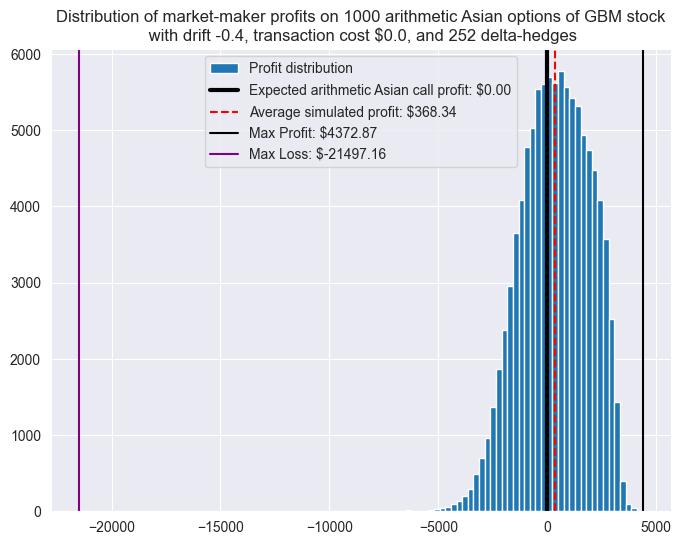

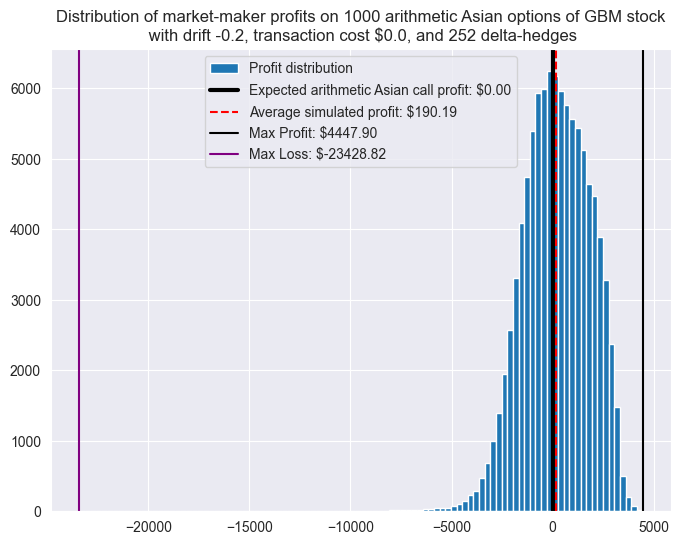

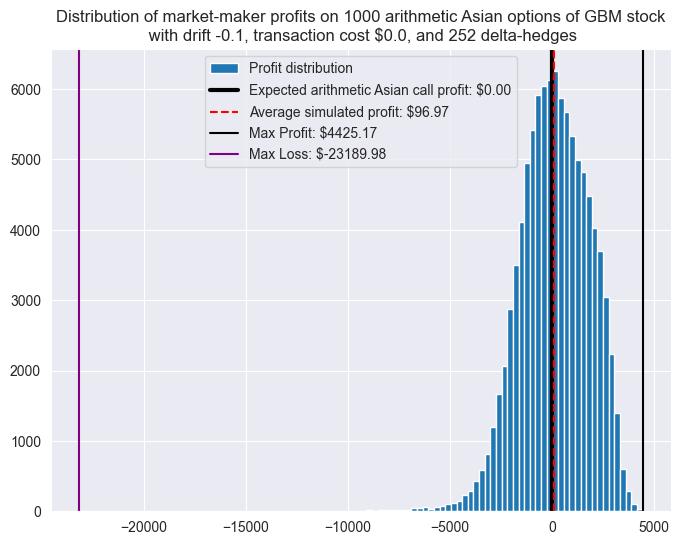

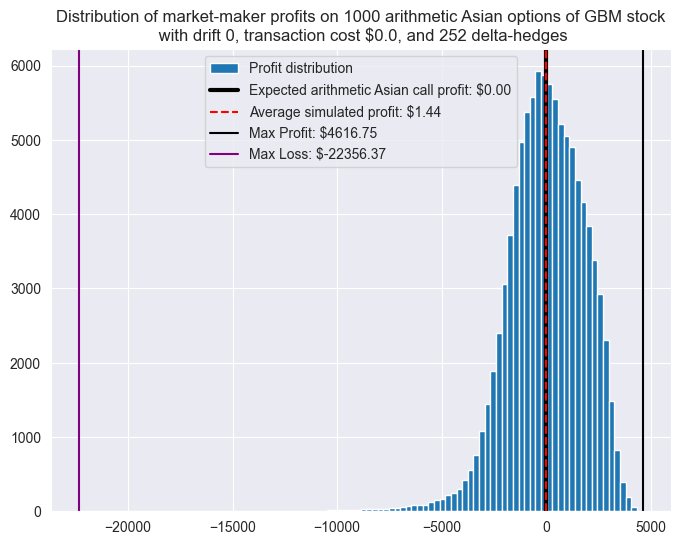

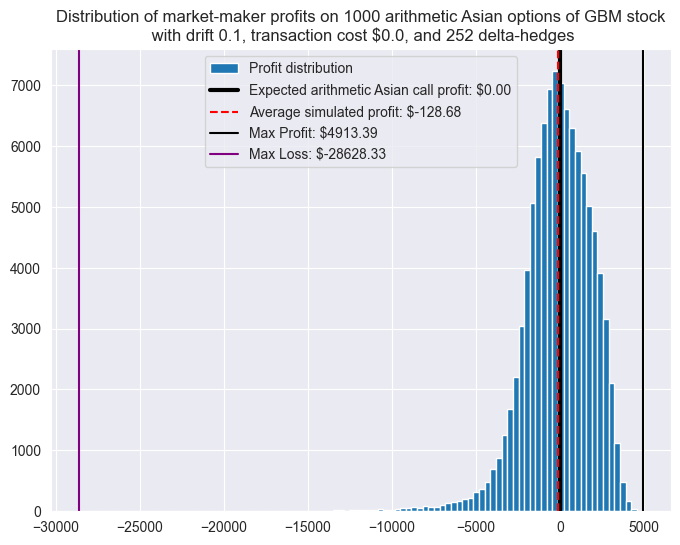

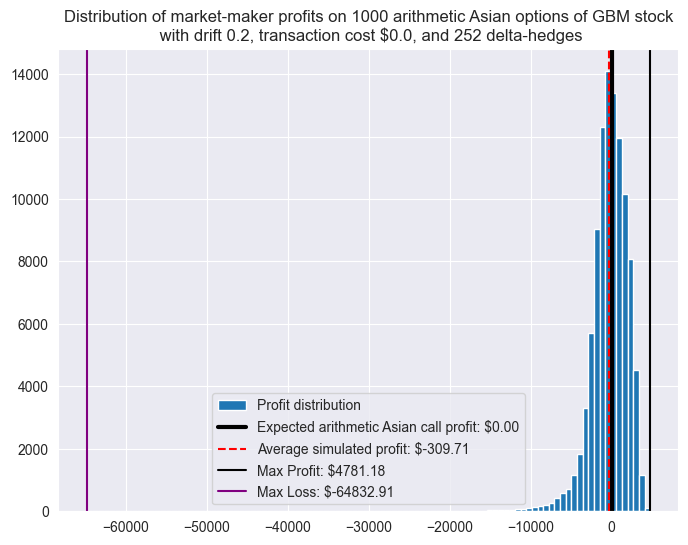

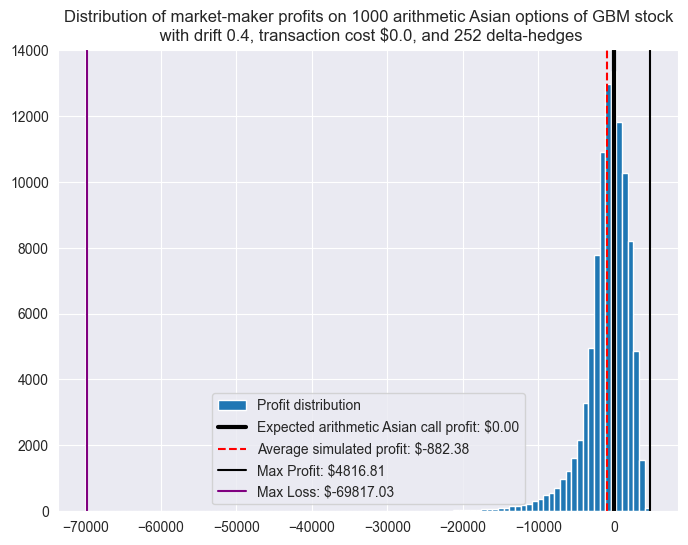

In [27]:
from utils import monte_carlo_asian

S0 = 100
K = 100
sigma = 0.41
t = 1
r = 0.045
n_sims = 100_000
tr_cost = 0.00
n_options = 1_000

n_steps = 252
# premium = monte_carlo_asian(
#     S0, K, sigma + 0.05, t, r, 0, n_sims, n_steps, return_distribution=False
# )
aao_price = monte_carlo_asian(
    S0, K, sigma, t, r, 0, n_sims, n_steps, return_distribution=False
)
premium = aao_price

mu_amounts = [-0.4, -0.2, -0.1, 0, 0.1, 0.2, 0.4]
profit_averages = []
profit_stds = []
profit_maxs = []
profit_mins = []

for mu in mu_amounts:
    unit_profits_distribution = mc_asian_sf_hedged(
        S0, K, sigma, t, r, mu, premium, n_sims, n_steps, geometric=False
    )

    profit_distribution = n_options * (unit_profits_distribution - tr_cost * n_steps)
    average_profit = np.mean(profit_distribution)
    profit_averages.append(average_profit)
    profit_stds.append(np.std(profit_distribution))

    plt.figure(figsize=(8, 6))

    plt.hist(profit_distribution, bins=100, label="Profit distribution")

    plt.axvline(
        n_options * (premium - aao_price),
        color="black",
        lw=3,
        label=f"Expected arithmetic Asian call profit: ${n_options*(premium - aao_price):.2f}",
    )

    plt.axvline(
        average_profit,
        ls="--",
        color="red",
        label=f"Average simulated profit: ${average_profit:.2f}",
    )

    profit_max = np.max(profit_distribution)
    profit_maxs.append(profit_max)
    profit_min = np.min(profit_distribution)
    profit_mins.append(profit_min)
    plt.axvline(profit_max, color="black", label=f"Max Profit: ${profit_max:.2f}")
    plt.axvline(profit_min, color="purple", label=f"Max Loss: ${profit_min:.2f}")

    plt.title(
        f"Distribution of market-maker profits on {n_options} arithmetic Asian options of GBM stock\n with drift {mu}, transaction cost ${tr_cost}, and {n_steps} delta-hedges"
    )
    plt.legend()
    plt.show()

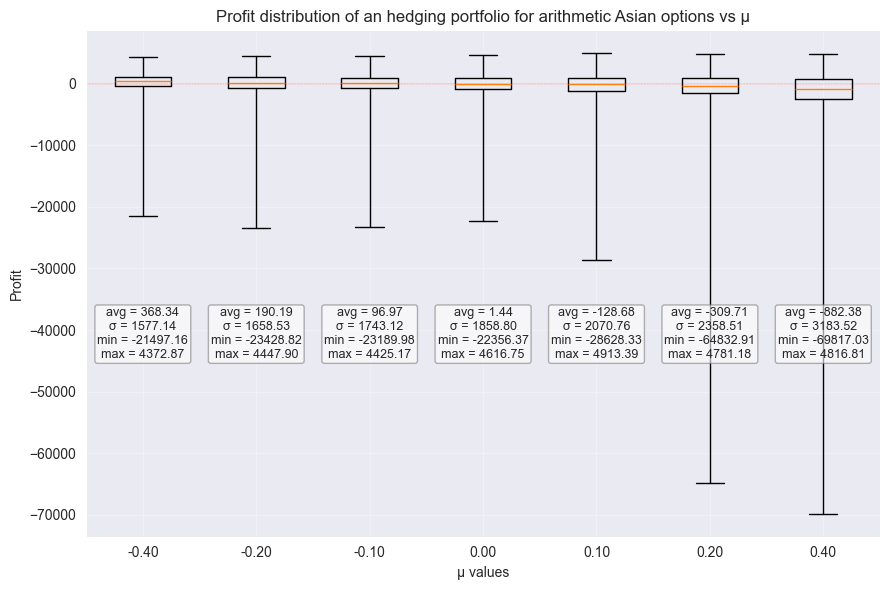

In [ ]:
# draw a box plot
box_data = []
for mean, std, minv, maxv in zip(
    profit_averages, profit_stds, profit_mins, profit_maxs
):
    q1 = mean - 0.5 * std
    q3 = mean + 0.5 * std
    median = mean
    box_data.append(
        {
            "med": median,
            "q1": q1,
            "q3": q3,
            "whislo": minv,  # bottom whisker
            "whishi": maxv,  # top whisker
            "fliers": [],
        }
    )

# Create boxplot
fig, ax = plt.subplots(figsize=(9, 6))
ax.bxp(box_data, showfliers=False)

# Label x-axis with mu values
ax.set_xticks(np.arange(1, len(mu_amounts) + 1))
ax.set_xticklabels([f"{mu:.2f}" for mu in mu_amounts])

ax.set_xlabel("μ values")
ax.set_ylabel("Profit")
ax.set_title(
    "Profit distribution of an hedging portfolio for arithmetic Asian options vs μ"
)

# Add annotations for each box
for i, (mu, mean, std, minv, maxv) in enumerate(
    zip(mu_amounts, profit_averages, profit_stds, profit_mins, profit_maxs), start=1
):
    text = f"avg = {mean:.2f}\nσ = {std:.2f}\nmin = {minv:.2f}\nmax = {maxv:.2f}"
    ax.text(
        i,  # x-position (box number)
        -45000,  # y just above whisker
        text,
        ha="center",
        va="bottom",
        fontsize=9,
        bbox=dict(
            facecolor="white", alpha=0.6, edgecolor="gray", boxstyle="round,pad=0.2"
        ),
    )

plt.axhline(y=0, color="r", linestyle="--", linewidth=0.2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In this case, the strategy has more sensibility to the drift term, which should be expected since the delta used is the one of the geometric option.  In particular, larger losses occur, especially with positive drifts.  Note however that extreme events are quite sparse, and that the perfectly balanced portfolio (return of 0) is within one standard deviation from the mean for all drifts.